## Import libraries and read data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path = '/home/dan1dr/data/feature_frame.csv'
data = pd.read_csv(path)

### Understanding the problem

Develop a ML model that. given a user and product, predicts if the user would purchase it at that moment. Here will explore and select the model we will apply to the PoC. This model will be used to target users and send them a push notification. Relevant info:

- Current push notificiations have an open rate of 5%.
- Focus only on purchases of at least 5 items (shipping cost).
- Use only linear models to speed up the development.
- The result should allow Sales team to select an item from a list and segment the users for triggering that notification.
- Target: expected increase on monthly sales by 2% and uplift of 25% on selected items.

### Filtering and data preparation

In [4]:
data.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [5]:
num_items_ordered = data.groupby('order_id')['outcome'].sum()
filter = num_items_ordered[num_items_ordered >= 5].index

filtered_data = data[data['order_id'].isin(filter)]

print(f"Length initial data: {len(data)}")
print(f"Length filtered data: {len(filtered_data)}\n")

print(f"Unique orders initially: {data['order_id'].nunique()}")
print(f"Unique orders >= 5 items: {filtered_data['order_id'].nunique()}")

Length initial data: 2880549
Length filtered data: 2163953

Unique orders initially: 3446
Unique orders >= 5 items: 2603


In [6]:
print(num_items_ordered[num_items_ordered > 5].mean())
print(num_items_ordered[num_items_ordered > 5].median())

12.527332511302918
11.0


## Feature Engineering

According with previous assignments, we will select only the features that we think are more relevant for our prediction. Will make a few adjustments here and will be iterating along the notebook.

We will create a logistic regression model for the model. From there, we know this model may sensitive to feature scale (keep in mind potential feature scaling if model is poor). Additionaly, for feature selection, we will need to select relevant features to simplify it. The multicollinearity might play an important role, so we will be discarding highly correlated features. To sum up, we might need to create new feature that groups others.

The non-numeric cols will need to be enconded, so we could try applying one-hot encoding.

1. First, we will try to do some manual feature engineering.
2. Later, we will apply Lasso to force some coefficients to be zero and compare to our manual approach
3. Additionally, we might apply Ridge to see also the coefficients obtained (less extreme selection).

### 1. Manual

In [7]:
pd.set_option('display.max_columns', None)
filtered_data.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [48]:
# We will remeber the classification we did in previous notebook:

predicted = ['outcome']
information = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
numerical = ['user_order_seq', 'normalised_price', 'discount_pct', 'global_popularity',
            'count_adults', 'count_children', 'count_babies', 'count_pets', 
            'people_ex_baby', 'days_since_purchase_variant_id', 
            'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
            'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
                'std_days_to_buy_product_type']

categorical = ['product_type', 'vendor']
binary = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']

From numerical: 
- We will remove count_adults, count_children, count_pets and keep only count_adults, which seems to be highly representative. We will maintain count_babies as correlation it is not that high (0.15) and may provide info.
- We will remove std_days_to_buy_product_type and keep avg_days_to_buy_product_type (highly correlated between themselves. We may do it reversely also)
- We will remove std_days_to_buy_variant_id and keep avg_days_to_buy_variant_id (same thing)

From categorical:
- We will remove vendor and keep product_type (the former has too different values). Later we will apply one-hot encoding

From binary: 
- We would try to use some resampling technique for grouping the 4 into just 1. We will create a column 'any_event' to input value '1' if any of the four cols has a value of 1. In this sense, we address the unbalanced distribution (a bit), we simplify it and also keep the info if any of these events occured


In [49]:
# Remove numericals
numerical_remove = ['count_adults', 'count_children', 'count_babies',
                    'std_days_to_buy_product_type', 'std_days_to_buy_variant_id']
numerical = [col for col in numerical if col not in numerical_remove]

# Remove categoricals
categorical.remove('vendor')

# Create the binary one
filtered_data['any_event'] = filtered_data[['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']].any(axis=1).astype(int)
binary = ['any_event']
# I'm thinking if maybe would be interesting to perform a sume here. If any_event = 2 would be stronger than 1 and so, while also keeping info about events.


/tmp/ipykernel_486/1254836267.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['any_event'] = filtered_data[['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']].any(axis=1).astype(int)


Additionally, let's check if order_date is always equal to created_at (maybe some orders are created but not ordered until X days). If so, let's remove order_date (created_at is has also hour and minut info). Maybe hourly data would be crucial for planning the timing of sending notifications.

In [50]:
if len(filtered_data[filtered_data['order_date'] == filtered_data['created_at']]) == len(filtered_data):
    print("ofc")

In [51]:
information.remove('order_date')
information

['variant_id', 'order_id', 'user_id', 'created_at']

In [52]:
cols = information + numerical + categorical + binary + predicted
final_data = filtered_data[cols]

Time format encoding for created_at. Later we could inspect if this granularity it is too much and it is better to leave it at day_of_week info

In [53]:
#Verify created at has pandas date_format
final_data['created_at'] = pd.to_datetime(final_data['created_at'])

# Extract year, month, day, and hour as separate features
final_data['year'] = final_data['created_at'].dt.year
final_data['month'] = final_data['created_at'].dt.month
# Extract the day of the week (numerical, 1-7, starting with Monday as 1)
final_data['day_of_week'] = final_data['created_at'].dt.dayofweek + 1
final_data['hour'] = final_data['created_at'].dt.hour
final_data = final_data.drop(columns=['created_at'])

/tmp/ipykernel_486/1071411211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['created_at'] = pd.to_datetime(final_data['created_at'])
/tmp/ipykernel_486/1071411211.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['year'] = final_data['created_at'].dt.year
/tmp/ipykernel_486/1071411211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

One-hot encoding for product_type

In [54]:
# Apply one-hot encoding for 'vendor'
# Drop_first = True to get rid of an additional col. Binaries for keeping consistency as any_event
final_data = pd.get_dummies(final_data, columns=['product_type'], prefix='product', drop_first=True).astype(int)

print(final_data.shape)
final_data.head()

(2163953, 80)


,variant_id,order_id,user_id,user_order_seq,normalised_price,discount_pct,global_popularity,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,any_event,outcome,year,month,day_of_week,hour,product_allpurposecleaner,product_babyfood12months,product_babyfood6months,product_babymilkformula,product_babytoiletries,product_bathroomlimescalecleaner,product_bathshowergel,product_beer,product_binbags,product_bodyskincare,product_catfood,product_cereal,product_cleaningaccessories,product_coffee,product_condimentsdressings,product_cookingingredientsoils,product_cookingsaucesmarinades,product_delicatesstainremover,product_dental,product_deodorant,product_dishwasherdetergent,product_dogfood,product_driedfruitsnutsseeds,product_dryingironing,product_fabricconditionerfreshener,product_facialskincare,product_feedingweaning,product_femininecare,product_floorcleanerpolish,product_foodstorage,product_haircare,product_handsoapsanitisers,product_healthcarevitamins,product_homebaking,product_householdsundries,product_jamhoneyspreads,product_juicesquash,product_kidsdental,product_kidssnacks,product_kitchenovencleaner,product_kitchenrolltissues,product_longlifemilksubstitutes,product_maternity,product_nappies,product_nappypants,product_petcare,product_pickledfoodolives,product_premixedcocktails,product_ricepastapulses,product_shavinggrooming,product_snacksconfectionery,product_softdrinksmixers,product_superfoodssupplements,product_tea,product_tinspackagedfoods,product_toiletroll,product_washingcapsules,product_washingliquidgel,product_washingpowder,product_windowglasscleaner,product_wipescottonwool
0,33826472919172,2807985930372,3482464092292,3,0,0,0,0,2,33,42,30,30,0,0,2020,10,1,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,33826472919172,2808027644036,3466586718340,2,0,0,0,0,2,33,42,30,30,0,0,2020,10,1,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,33826472919172,2808099078276,3481384026244,4,0,0,0,0,2,33,42,30,30,0,0,2020,10,1,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,33826472919172,2808393957508,3291363377284,2,0,0,0,0,2,33,42,30,30,0,0,2020,10,2,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,33826472919172,2808434524292,3479090790532,3,0,0,0,0,2,33,42,30,30,0,0,2020,10,2,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


## Train model

Dataset seems to be big enough (2M rows), so we will split the data by i) 80% training set/ 10 validation/ 10 test; later ii) 70/15/15. Note that train_test_split applies a random selection (seed predefined for obtaining same values later on) with no replacement.

In [61]:
# Import model and split method
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Features and target variable
X = final_data.drop(columns='outcome')
y = final_data['outcome']

# Split the data and then split validation/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=33)

In [62]:
# Initialize model
model = LogisticRegression()

# Train
model.fit(X_train, y_train)

/home/dan1dr/.cache/pypoetry/virtualenvs/zrive-ds-UEx3J_CK-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [63]:
from sklearn.metrics import classification_report

# Validate the model
y_val_pred = model.predict(X_val)
print(classification_report(y_val, y_val_pred))

/home/dan1dr/.cache/pypoetry/virtualenvs/zrive-ds-UEx3J_CK-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dan1dr/.cache/pypoetry/virtualenvs/zrive-ds-UEx3J_CK-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1066387
           1       0.00      0.00      0.00     15589

    accuracy                           0.99   1081976
   macro avg       0.49      0.50      0.50   1081976
weighted avg       0.97      0.99      0.98   1081976



/home/dan1dr/.cache/pypoetry/virtualenvs/zrive-ds-UEx3J_CK-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
# Test the model
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

/home/dan1dr/.cache/pypoetry/virtualenvs/zrive-ds-UEx3J_CK-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dan1dr/.cache/pypoetry/virtualenvs/zrive-ds-UEx3J_CK-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1066237
           1       0.00      0.00      0.00     15740

    accuracy                           0.99   1081977
   macro avg       0.49      0.50      0.50   1081977
weighted avg       0.97      0.99      0.98   1081977



/home/dan1dr/.cache/pypoetry/virtualenvs/zrive-ds-UEx3J_CK-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model does not converge with the default number of iterations = 100. We will use the feature scaling provided by scikit in order to standardized the features and enable the estimator to learn from them easier. This will substract the mean from the feature and divide by the std.

In [57]:
from sklearn.preprocessing import StandardScaler

# Feature scaler and apply to X data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split again
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=33)

# Initialize model
model = LogisticRegression()

# Train
model.fit(X_train, y_train)

LogisticRegression()

In [59]:
# Validate the model
y_val_pred = model.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1066387
           1       0.60      0.00      0.00     15589

    accuracy                           0.99   1081976
   macro avg       0.79      0.50      0.50   1081976
weighted avg       0.98      0.99      0.98   1081976



In [60]:
# Test the model
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1066237
           1       0.33      0.00      0.00     15740

    accuracy                           0.99   1081977
   macro avg       0.66      0.50      0.50   1081977
weighted avg       0.98      0.99      0.98   1081977



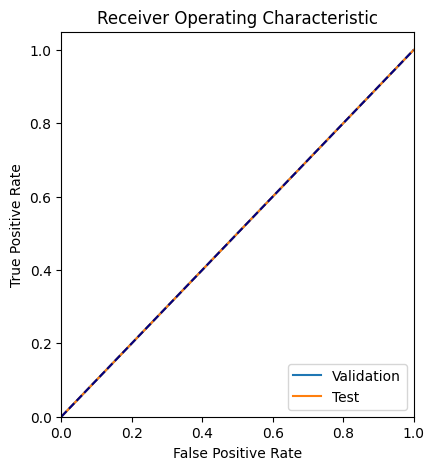

In [65]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Calculate probabilities for the positive class
y_val_probs = model.predict_proba(X_val)[:, 1]
y_test_probs = model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(fpr_val, tpr_val, label='Validation')
plt.plot(fpr_test, tpr_test, label='Test')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

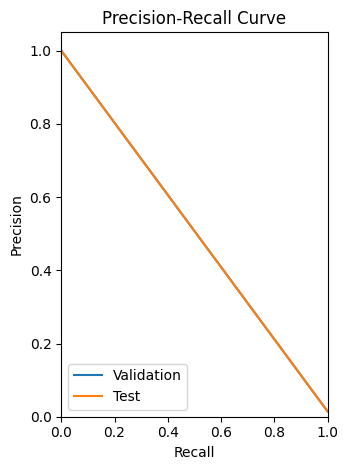

In [66]:
# Precision-Recall Curve
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_probs)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_probs)

plt.subplot(1, 2, 2)
plt.plot(recall_val, precision_val, label='Validation')
plt.plot(recall_test, precision_test, label='Test')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

Even with that, we see the model it is a total disaster for predicting the positive class like flipping a coin as classifier, despite being very good for the negative. This may come from the strongly unbalanced classes we had in the dataset

In [69]:
final_data['outcome'].value_counts()

outcome
0    2132624
1      31329
Name: count, dtype: int64

In [68]:
final_data['any_event'].value_counts()

any_event
0    2104207
1      59746
Name: count, dtype: int64

First, let's usee the weight_class that scikit offers. Then we could think of oversampling the minority class, or undersampling the majority. We have 2M rows, so undersampling might be a good idea since we might have enough data for doing that. Oversampling may disrupt the data and add new ones, but may work also

In [80]:
X = final_data.drop(columns='outcome')
y = final_data['outcome']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split again
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=33)

# Initialize model with class_weight='balanced'
model = LogisticRegression(class_weight='balanced')

# Train
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [81]:
# Validate the model
y_val_pred = model.predict(X_val)
print(classification_report(y_val, y_val_pred))

# Test the model
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.78      0.87   1066387
           1       0.04      0.62      0.07     15589

    accuracy                           0.78   1081976
   macro avg       0.52      0.70      0.47   1081976
weighted avg       0.98      0.78      0.86   1081976

              precision    recall  f1-score   support

           0       0.99      0.78      0.87   1066237
           1       0.04      0.61      0.07     15740

    accuracy                           0.78   1081977
   macro avg       0.52      0.70      0.47   1081977
weighted avg       0.98      0.78      0.86   1081977



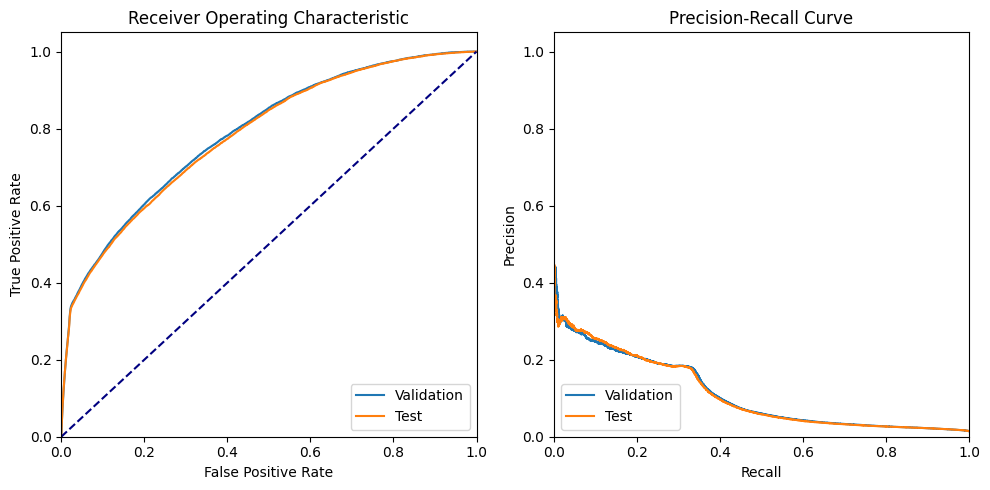

In [82]:
# Calculate probabilities for the positive class
y_val_probs = model.predict_proba(X_val)[:, 1]
y_test_probs = model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(fpr_val, tpr_val, label='Validation')
plt.plot(fpr_test, tpr_test, label='Test')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")


# Precision-Recall Curve
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_probs)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_probs)

plt.subplot(1, 2, 2)
plt.plot(recall_val, precision_val, label='Validation')
plt.plot(recall_test, precision_test, label='Test')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

Let's also try luck using UnderSampler from under_sampling library AFTER the split data, for avoiding information leakage (another method for undersampling data)

In [83]:
from imblearn.under_sampling import RandomUnderSampler

# Feature scaler and apply to X data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split again
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=33)

# Define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# Fit and apply the transform to the training data
X_train, y_train = undersample.fit_resample(X_train, y_train)

# Train your model on the undersampled training data
model.fit(X_train, y_train)

# Predict the outcomes for the validation data
y_val_pred = model.predict(X_val)

# Print the classification report for validation results
print("Validation Results:")
print(classification_report(y_val, y_val_pred))

# Predict the outcomes for the test data
y_test_pred = model.predict(X_test)

# Print the classification report for test results
print("Test Results:")
print(classification_report(y_test, y_test_pred))


Validation Results:
              precision    recall  f1-score   support

           0       0.99      0.77      0.87   1066387
           1       0.04      0.63      0.07     15589

    accuracy                           0.77   1081976
   macro avg       0.52      0.70      0.47   1081976
weighted avg       0.98      0.77      0.86   1081976

Test Results:
              precision    recall  f1-score   support

           0       0.99      0.77      0.87   1066237
           1       0.04      0.62      0.07     15740

    accuracy                           0.77   1081977
   macro avg       0.52      0.70      0.47   1081977
weighted avg       0.98      0.77      0.86   1081977



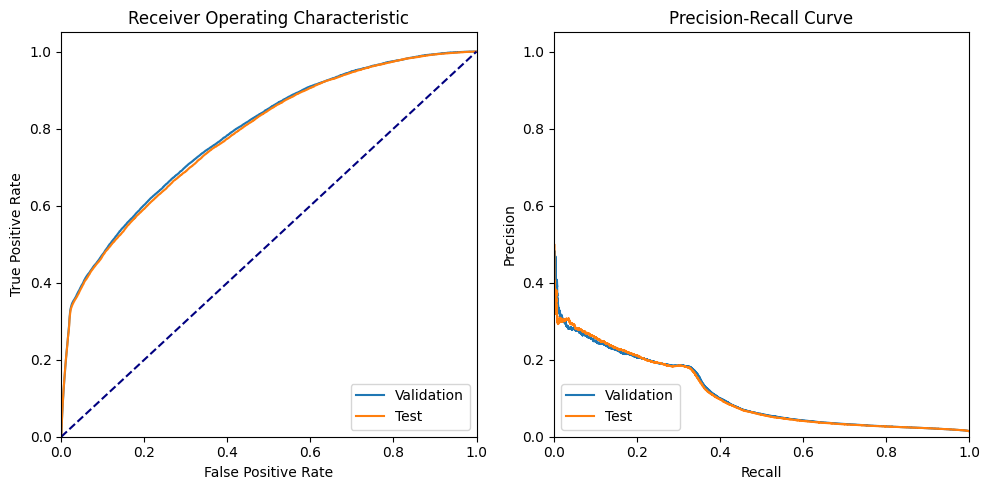

In [84]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Calculate probabilities for the positive class
y_val_probs = model.predict_proba(X_val)[:, 1]
y_test_probs = model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(fpr_val, tpr_val, label='Validation')
plt.plot(fpr_test, tpr_test, label='Test')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")


# Precision-Recall Curve
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_probs)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_probs)

plt.subplot(1, 2, 2)
plt.plot(recall_val, precision_val, label='Validation')
plt.plot(recall_test, precision_test, label='Test')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

We obtain basically almost the exact same result (which is weird becuase both ways of dealing with the unbalanced is very different).

Now, with these results, let's pause for a moment and analyze the numbers obtained:

- Precision (True positive / true positive + false positive). Measures the accuracy of positive predictions. If the model predicts a purchase won't happen, it is correct almost always. If it predicts it will happen, only is correct 4% of the time (generating lots of false positives). Remember that current push open rate is around 5%, so we're not improving anything with this.

- Recall or true positive rate (True positive / true positive + false negative). Measures the ability to identify all positives. If model predicts no purchase, it identifies 77% of the time (a bit of false purchases). If the model predicts a purchase, it identifies 63% of the purchases (a bit more of false no-purchases)

- ROC Curve. Knowing that classes are strongly unbalanced, we can appreciate a few things: We start to generate false alarms very quickly, as provided by precision before. When 50% of the alarms are false (FPR at 0.5), we are identifying 80% of the positive alarms. Then the number of false alarms grow very quickly (so basically we will be spamming the user)

- Precision-recall curve. Precision decreases very fast for almost no recall (loss of accuracy of positive predictions when trying to gain sensivity).

Regarding ROC curve, we should expect 


